In [2]:
import xarray as xr
from pathlib import Path
import numpy as np
import warnings

import matplotlib.pyplot as plt
from matplotlib import patches

import functions.eddy_feedback as ef
import functions.data_wrangling as data

import wavenumber as waves

In [3]:
data_path = Path('/home/links/ct715/data_storage/reanalysis/srip_datasets/original')

models = ['ERA-Interim']
dataset_type = ['TEM', 'ZMD']

ds = {}
for model in models:
    
    # set paths and import datasets into one set
    dataset_paths = data_path.glob(f'{model}_*_monthly_original.nc')
    dataset = xr.open_mfdataset(
        dataset_paths,
        parallel=True
    )
    
    # bespoke changes
    dataset = dataset.rename({'u': 'ubar'})

    # save to dataset dict
    ds[model] = dataset
    
era = ds['ERA-Interim']

In [4]:
for model in ds:
    print(f"{model}: {ef.calculate_efp(ds[model], data_type='reanalysis', which_div1='EPFD_phi_pr')}, {ef.calculate_efp(ds[model], data_type='reanalysis', which_div1='EPFD_phi_pr', calc_south_hemis=True)}")
    
    
    ds[model]['k1-3'] = ds[model].EPFD_phi_pr_k1 + ds[model].EPFD_phi_pr_k2 + ds[model].EPFD_phi_pr_k3
    ds[model]['k>3'] = ds[model].EPFD_phi_pr - ds[model]['k1-3']
    
    # ds[model] = data.data_checker1000(ds[model])
  
wavenumber = ['k1', 'k2', 'k3']  
other_waves = ['k1-3', 'k>3']

ERA-Interim: 0.4421, 0.3716


***

# Plot correlations

0.0612
0.1501
0.0669


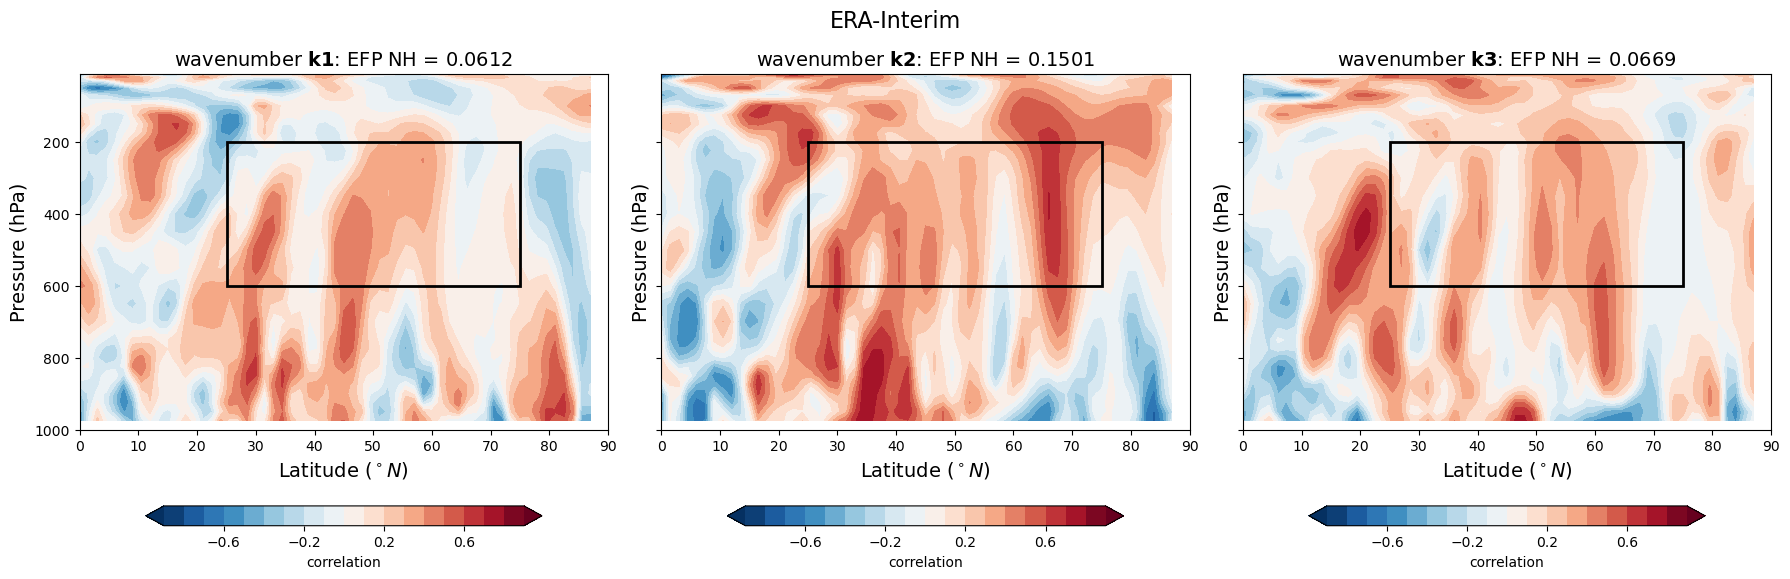

In [5]:
for model in ds:
    fig, axes = plt.subplots(ncols=3, figsize=(18, 6), sharey=True)

    for ax, n in zip(axes, wavenumber):
        efp = ef.calculate_efp(ds[model], data_type='reanalysis', which_div1=f'EPFD_phi_pr_{n}')
        print(efp)
        waves.plot_wavenumber_EFP_correlation(ax, ds[model], data_type='reanalysis', which_div1=f'EPFD_phi_pr_{n}', 
                            hemisphere='NH', title=f'wavenumber $\\mathbf{{{n}}}$: EFP NH = {efp}', logscale=False)
        
    fig.suptitle(model, fontsize=16)

plt.tight_layout()
plt.show()

0.1835
0.2111


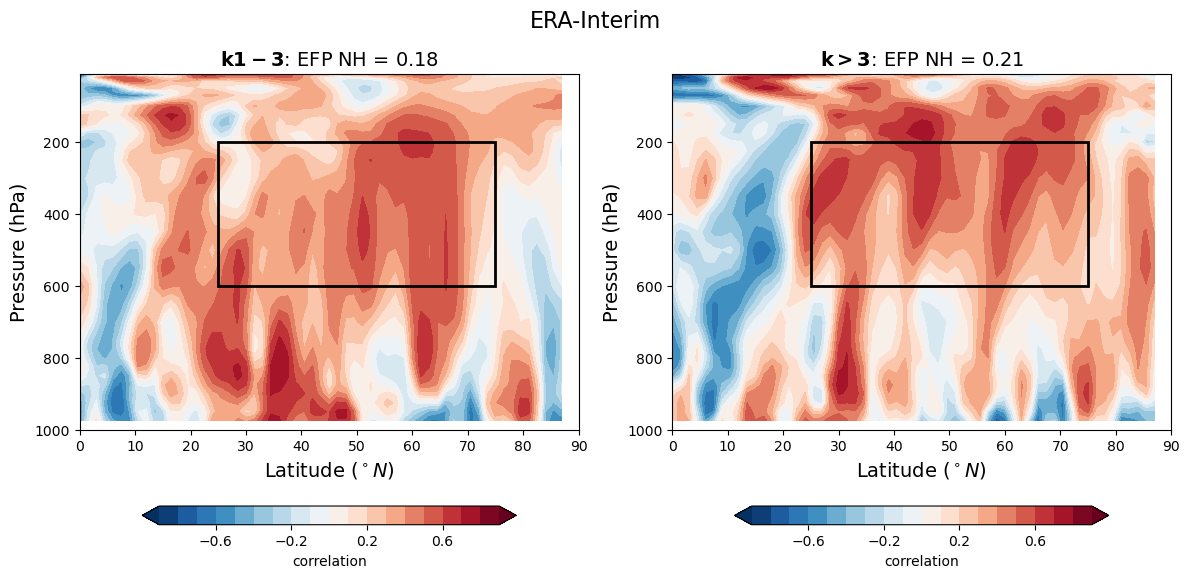

In [6]:
for model in ds:
    fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

    for ax, n in zip(axes, other_waves):
        efp = ef.calculate_efp(ds[model], data_type='reanalysis', which_div1=n)
        print(efp)
        waves.plot_wavenumber_EFP_correlation(ax, ds[model], data_type='reanalysis', which_div1=n, hemisphere='NH', 
                                              title=f'$\\mathbf{{{n}}}$: EFP NH = {round(float(efp),2)}', logscale=False)

    fig.suptitle(model, fontsize=16)

plt.tight_layout()
plt.show()

# Southern Hemisphere

0.0366
0.3123


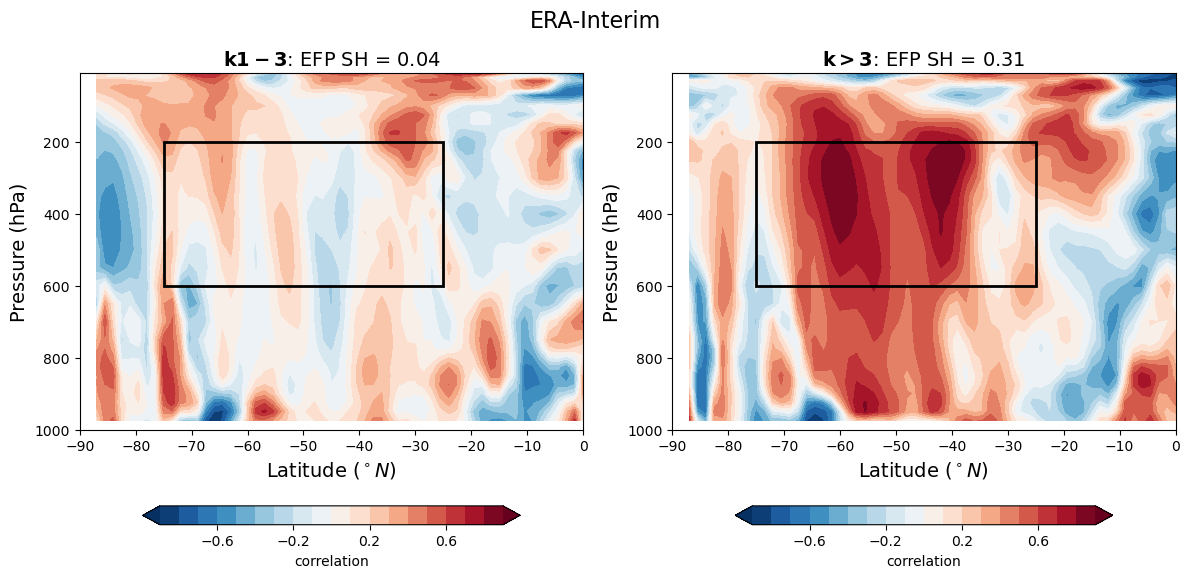

In [7]:
for model in ds:
    fig, axes = plt.subplots(ncols=2, figsize=(12, 6))

    for ax, n in zip(axes, other_waves):
        efp = ef.calculate_efp(ds[model], data_type='reanalysis', which_div1=n, calc_south_hemis=True)
        print(efp)
        waves.plot_wavenumber_EFP_correlation(ax, ds[model], data_type='reanalysis', which_div1=n, hemisphere='SH', 
                                              title=f'$\\mathbf{{{n}}}$: EFP SH = {round(float(efp),2)}', logscale=False)

    fig.suptitle(model, fontsize=16)

plt.tight_layout()
plt.show()

# Combined hemispheres

In [11]:
def plot_wavenumber_EFP_correlation(ax, ds, data_type, logscale=True, show_rect=True, hemisphere='NH',
                                    top_atmos=10., cut_poles=False, title='', take_seasonal=True,
                                    which_div1='div1_pr', add_colorbar=True):
    """
    Input: DataArrays of ubar and F_phi
            - Dims: (time, level, lat)
                - DATASET MUST BE FULL YEAR FOR SEASONAL MEAN 
            - Subsetted to NH or SH
            - Cut off stratosphere >10. hPa
    
    Output: contourf plot matching Fig.6a in Smith et al., 2022 
    """

    ## DATA CHECKS
    
    data_type_mapping = {
        'reanalysis': which_div1,
        'reanalysis_qg': 'div1_qg',
        'pamip': None,
        'isca': 'div1'
    }
    if data_type not in data_type_mapping:
        raise ValueError(f'Invalid data_type: {data_type}. Expected one of {list(data_type_mapping.keys())}.')

    if data_type == 'pamip':
        if 'divF' in ds.variables:
            which_div1 = 'divF'
        elif 'divFy' in ds.variables:
            which_div1 = 'divFy'
        else:
            raise ValueError("Neither 'divF' nor 'divFy' found in dataset for pamip data type.")
    else:
        which_div1 = data_type_mapping.get(data_type)
        
    ds = data.data_checker1000(ds)

    if hemisphere == 'NH':
        ds = ds.where(ds.lat >= 0., drop=True)
        rect_box = (25., 600.)
        season = 'djf'
    elif hemisphere == 'SH':
        ds = ds.where(ds.lat <= 0., drop=True)
        rect_box = (-75., 600.)
        season = 'jas'
    else:
        print('Hemisphere not specified')

    if take_seasonal:
        ds = ds.sel(time=slice('1979', '2016'))
        ds = data.seasonal_mean(ds, season=season)

    ubar = ds.ubar
    div1 = ds[which_div1]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        corr = xr.corr(div1, ubar, dim='time').load()

    corr = corr.where(corr.level >= top_atmos, drop=True)

    if cut_poles:
        corr = corr.where(corr.lat >= -85., drop=True)
        corr = corr.where(corr.lat <= 85., drop=True)

    # Plotting
    contour = ax.contourf(corr.lat.values, corr.level.values, corr, cmap='RdBu_r',
                          levels=np.linspace(-0.9, 0.9, 19), extend='both')
    
    if add_colorbar:
        plt.colorbar(contour, ax=ax, location='bottom', orientation='horizontal', shrink=0.75,
                     label='correlation', extend='both', ticks=[-0.6, -0.2, 0.2, 0.6])

    ax.invert_yaxis()
    ax.set_xlabel('Latitude $(^\\circ N)$', fontsize=14)
    if logscale:
        ax.set_yscale('log')
        ax.set_ylabel('Log pressure (hPa)', fontsize=14)
    else:
        ax.set_ylabel('Pressure (hPa)', fontsize=14)

    ax.set_title(f'{title}', fontsize=14)

    if show_rect:
        rect = patches.Rectangle(rect_box, 50, -400, fill=False, linewidth=2)
        ax.add_patch(rect)

    return contour  # Optionally return contour object

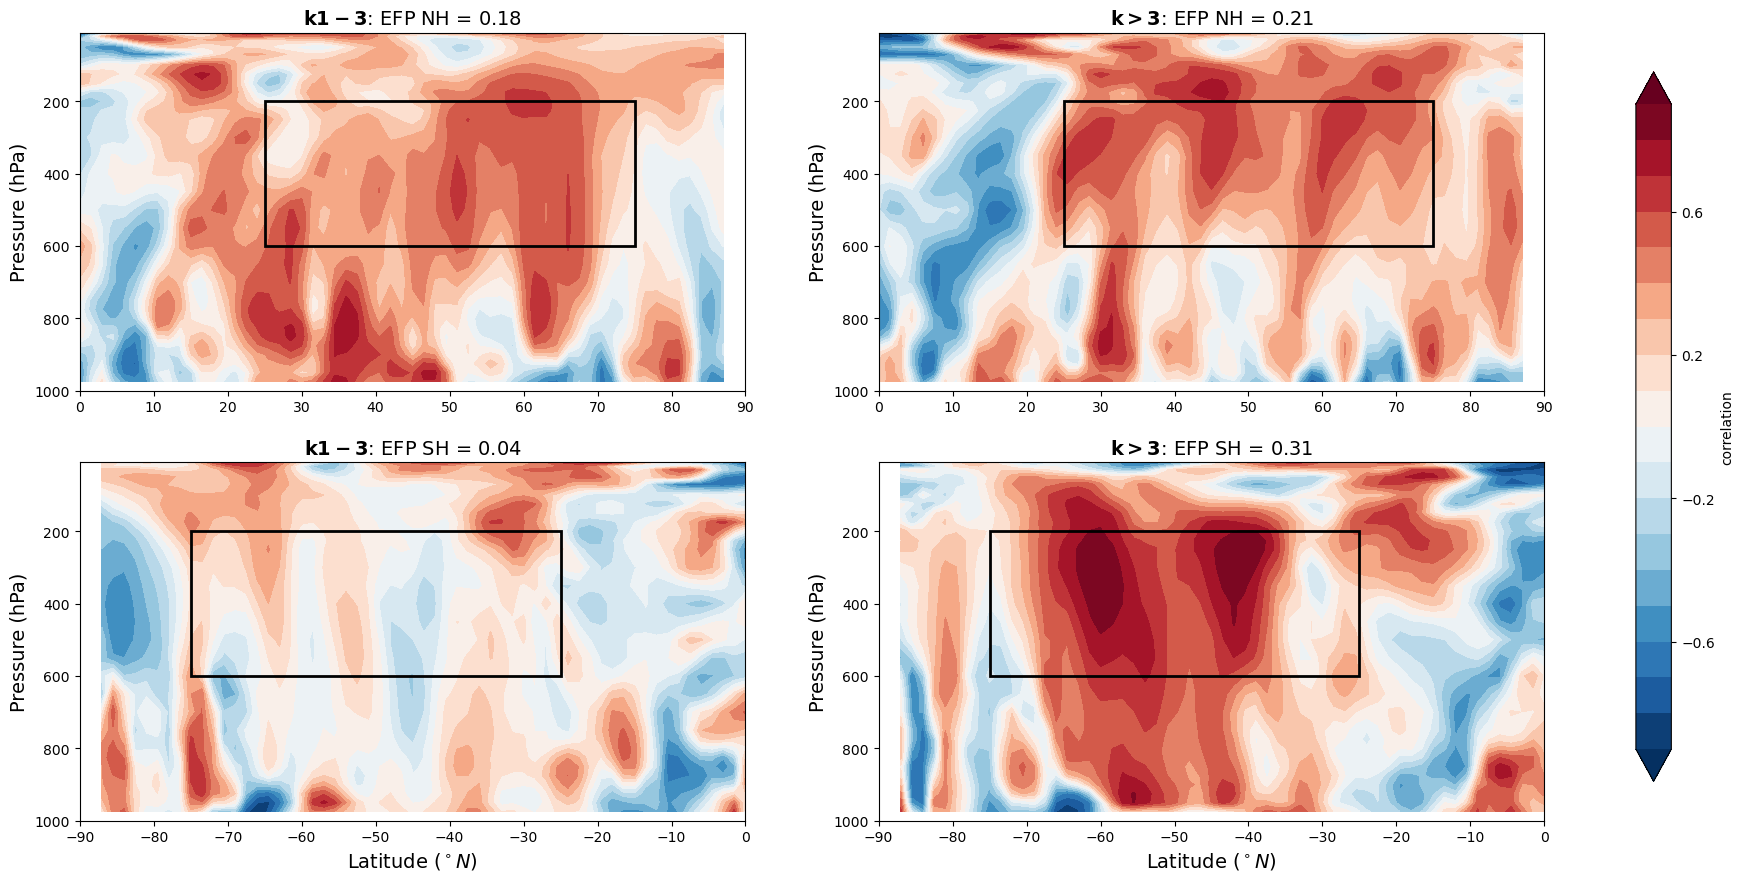

In [21]:
def mm_to_inches(mm):
    return mm / 25.4

# Example usage:
width_mm = 300  # e.g., full-page width in a journal
height_mm = 130

figsize = (mm_to_inches(width_mm*2), mm_to_inches(height_mm*2))

for model in ds:
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=figsize)
    
    top_axes = axes[0]
    bottom_axes = axes[1]
    
    # Store one of the contour objects to use for the shared colorbar
    contour_for_cbar = None

    for ax, n in zip(top_axes, other_waves[:2]):
        efp = ef.calculate_efp(ds[model], data_type='reanalysis', which_div1=n, calc_south_hemis=False)
        contour = plot_wavenumber_EFP_correlation(
            ax, ds[model], data_type='reanalysis', which_div1=n, hemisphere='NH',
            title=f'$\\mathbf{{{n}}}$: EFP NH = {round(float(efp), 2)}', logscale=False,
            add_colorbar=False
        )
        ax.set_xlabel('')
        if contour_for_cbar is None:
            contour_for_cbar = contour

    for ax, n in zip(bottom_axes, other_waves[:2]):        
        efp = ef.calculate_efp(ds[model], data_type='reanalysis', which_div1=n, calc_south_hemis=True)      
        contour = plot_wavenumber_EFP_correlation(
            ax, ds[model], data_type='reanalysis', which_div1=n, hemisphere='SH',
            title=f'$\\mathbf{{{n}}}$: EFP SH = {round(float(efp), 2)}', logscale=False,
            add_colorbar=False
        )
        
        if contour_for_cbar is None:
            contour_for_cbar = contour

    # Add one shared colorbar on the right-hand side
    cbar = fig.colorbar(
        contour_for_cbar,
        ax=axes.ravel().tolist(),
        orientation='vertical',
        shrink=0.9,
        label='correlation',
        ticks=[-0.6, -0.2, 0.2, 0.6],
        extend='both'
    )

    # fig.suptitle(model, fontsize=16)
    # plt.tight_layout()
    plt.savefig('./plots/poster_wavenumber_4plots.png', bbox_inches='tight', dpi=300)
    plt.show()